In [1]:
# === 1. Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from deap import base, creator, tools, algorithms

In [2]:
# === 2. Load Dataset ===
df = pd.read_csv("Lung Cancer Dataset.csv")
df['PULMONARY_DISEASE'] = df['PULMONARY_DISEASE'].map({'YES': 1, 'NO': 0})  # Encoding target variable


In [3]:
# Pisahkan fitur dan target
X = df.drop(columns=['PULMONARY_DISEASE'])
y = df['PULMONARY_DISEASE']

In [4]:
# Konversi fitur kategori ke numerik (jika ada)
X = pd.get_dummies(X)

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# === 3. Parameter Genetic Algorithm ===
POPULATION_SIZE = 20  # Ukuran populasi
N_GENERATIONS = 50  # Jumlah iterasi generasi
MUTATION_RATE = 0.2  # Peluang mutasi

In [8]:
# Inisialisasi GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)



D:\laragon\bin\python\python-3.10\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\laragon\bin\python\python-3.10\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [9]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
# === 4. Genetic Algorithm for Feature Selection (Random Forest) ===
def evaluate_rf(individual):
    selected_features = [col for i, col in enumerate(X.columns) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0,
    X_selected = X[selected_features]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = accuracy_score(y_test_sel, model.fit(X_train_sel, y_train_sel).predict(X_test_sel))
    return scores,

toolbox.register("evaluate", evaluate_rf)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=MUTATION_RATE)
toolbox.register("select", tools.selTournament, tournsize=3)

In [11]:
# Simpan nilai fitness terbaik tiap generasi
best_fitness_per_generation = []

In [14]:
# Jalankan GA untuk RF
population = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(1)

# Menjalankan GA dalam satu kali pemanggilan untuk semua generasi
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("avg", np.mean)

print(f"Running Genetic Algorithm for {N_GENERATIONS} generations...\n")

# Jalankan GA satu kali untuk semua generasi
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, 
                                          ngen=N_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# Simpan nilai fitness terbaik dari setiap generasi
best_fitness_per_generation = logbook.select("max")

# Pastikan bahwa GA berhasil menemukan individu terbaik
if len(hof) > 0:
    best_features_rf = [col for i, col in enumerate(X.columns) if hof[0][i] == 1]
    print("\nFitur Terbaik yang Dipilih oleh GA untuk Random Forest:")
    print(best_features_rf)
else:
    print("⚠️ GA tidak menemukan individu terbaik. Periksa kembali parameter GA.")
    best_features_rf = []


Running Genetic Algorithm for 50 generations...

gen	nevals	max  	min  	avg    
0  	20    	0.863	0.555	0.70265
1  	9     	0.863	0.598	0.76295
2  	13    	0.87 	0.729	0.81445
3  	16    	0.87 	0.81 	0.85515
4  	13    	0.877	0.789	0.8604 
5  	8     	0.87 	0.722	0.85895
6  	7     	0.87 	0.685	0.8536 
7  	14    	0.87 	0.701	0.84435
8  	13    	0.87 	0.686	0.84225
9  	11    	0.883	0.746	0.86445
10 	10    	0.901	0.723	0.8619 
11 	17    	0.901	0.694	0.84005
12 	6     	0.91 	0.683	0.8579 
13 	12    	0.915	0.702	0.86945
14 	11    	0.915	0.664	0.8784 
15 	10    	0.915	0.843	0.90685
16 	11    	0.915	0.781	0.90505
17 	10    	0.915	0.909	0.91355
18 	10    	0.915	0.78 	0.897  
19 	17    	0.915	0.576	0.87915
20 	7     	0.915	0.771	0.9055 
21 	13    	0.915	0.752	0.8911 
22 	12    	0.915	0.727	0.8924 
23 	11    	0.915	0.867	0.9126 
24 	10    	0.915	0.739	0.89975
25 	12    	0.915	0.789	0.8931 
26 	13    	0.922	0.688	0.89525
27 	16    	0.922	0.702	0.8936 
28 	9     	0.922	0.78 	0.90405
29 	16    	0.922	0.71

In [15]:
# === 5. Genetic Algorithm for Feature Selection (XGBoost) ===
def evaluate_xgb(individual):
    selected_features = [col for i, col in enumerate(X.columns) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0,
    X_selected = X[selected_features]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
    scores = accuracy_score(y_test_sel, model.fit(X_train_sel, y_train_sel).predict(X_test_sel))
    return scores,

toolbox.register("evaluate", evaluate_xgb)

In [16]:
# Simpan nilai fitness terbaik tiap generasi untuk XGBoost
best_fitness_per_generation_xgb = []

In [19]:
# Jalankan GA untuk XGBoost
population = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(1)

# Menjalankan GA dalam satu kali pemanggilan untuk semua generasi
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("avg", np.mean)

print(f"Running Genetic Algorithm for XGBoost with {N_GENERATIONS} generations...\n")

# Jalankan GA satu kali untuk semua generasi
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, 
                                          ngen=N_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# Simpan nilai fitness terbaik dari setiap generasi
#best_fitness_per_generation_xgb = logbook.select("max")
best_fitness_per_generation_xgb = logbook.select("max")[1:]  # Hilangkan nilai generasi 0
# Pastikan bahwa GA berhasil menemukan individu terbaik
if len(hof) > 0:
    best_features_xgb = [col for i, col in enumerate(X.columns) if hof[0][i] == 1]
    print("\nFitur Terbaik yang Dipilih oleh GA untuk XGBoost:")
    print(best_features_xgb)
else:
    print("⚠️ GA tidak menemukan individu terbaik untuk XGBoost. Periksa kembali parameter GA.")
    best_features_xgb = []


Running Genetic Algorithm for XGBoost with 50 generations...

gen	nevals	max 	min  	avg    
0  	20    	0.83	0.562	0.71935
1  	11    	0.85	0.676	0.7749 
2  	10    	0.865	0.693	0.8154 
3  	10    	0.905	0.745	0.83735
4  	12    	0.906	0.722	0.84905
5  	10    	0.909	0.799	0.88645
6  	9     	0.909	0.805	0.89615
7  	11    	0.909	0.705	0.8855 
8  	14    	0.909	0.813	0.90115
9  	14    	0.909	0.727	0.89045
10 	14    	0.909	0.789	0.9028 
11 	14    	0.909	0.664	0.8636 
12 	8     	0.909	0.793	0.90265
13 	2     	0.909	0.872	0.90715
14 	8     	0.909	0.799	0.9034 
15 	8     	0.909	0.671	0.86955
16 	13    	0.911	0.629	0.8891 
17 	9     	0.911	0.751	0.8949 
18 	11    	0.911	0.712	0.88685
19 	15    	0.911	0.604	0.8629 
20 	8     	0.911	0.831	0.90045
21 	16    	0.911	0.771	0.89025
22 	10    	0.911	0.713	0.8848 
23 	10    	0.911	0.685	0.89125
24 	11    	0.911	0.782	0.8944 
25 	13    	0.911	0.718	0.8812 
26 	15    	0.911	0.777	0.9019 
27 	13    	0.911	0.777	0.89755
28 	14    	0.911	0.762	0.90105
29 	16    	

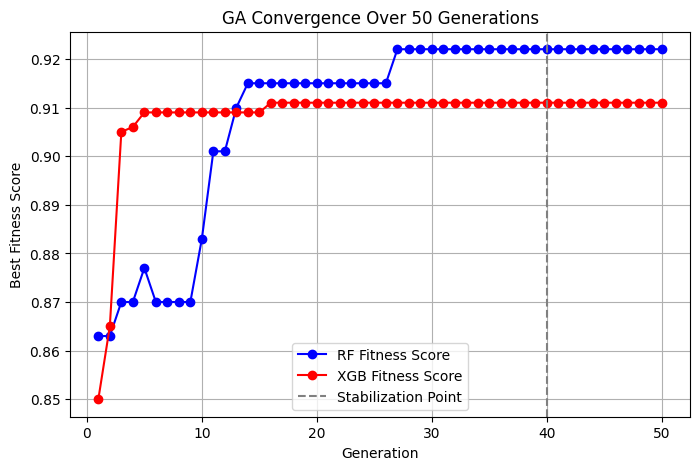

In [22]:
# === 6. Visualisasi Konvergensi GA ===
plt.figure(figsize=(8, 5))

# Pastikan jumlah data cocok dengan jumlah generasi
generations = list(range(1, N_GENERATIONS+1))  # Mulai dari 1 agar generasi 0 tidak ikut

# Plot konvergensi untuk Random Forest
plt.plot(generations, best_fitness_per_generation[:N_GENERATIONS], 
         marker='o', linestyle='-', color='b', label='RF Fitness Score')

# Plot konvergensi untuk XGBoost
plt.plot(generations, best_fitness_per_generation_xgb[:N_GENERATIONS], 
         marker='o', linestyle='-', color='r', label='XGB Fitness Score')

# Garis vertikal sebagai tanda stabilisasi
plt.axvline(x=40, linestyle='--', color='gray', label='Stabilization Point')

# Judul dan label
plt.title("GA Convergence Over 50 Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.legend()
plt.grid()

# Tampilkan grafik
plt.show()


In [23]:
# === 7. Evaluasi Model ===
def evaluate_model(model, X_train, X_test, y_train, y_test, desc):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    return [desc, acc, precision, recall, f1, auc]

results=[]

In [24]:
# Evaluasi Random Forest
results.append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, "Random Forest Sebelum GA"))
results.append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), X_train[best_features_rf], X_test[best_features_rf], y_train, y_test, "Random Forest Setelah GA"))


In [25]:
# Evaluasi XGBoost
results.append(evaluate_model(XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss"), X_train, X_test, y_train, y_test, "XGBoost Sebelum GA"))
results.append(evaluate_model(XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss"), X_train[best_features_xgb], X_test[best_features_xgb], y_train, y_test, "XGBoost Setelah GA"))


In [26]:
# Menampilkan hasil evaluasi dalam bentuk tabel
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"])
print(df_results)

                      Model  Accuracy  Precision    Recall  F1-score   AUC-ROC
0  Random Forest Sebelum GA     0.913   0.903302  0.892774  0.898007  0.910485
1  Random Forest Setelah GA     0.922   0.916865  0.899767  0.908235  0.919235
2        XGBoost Sebelum GA     0.903   0.880734  0.895105  0.887861  0.902018
3        XGBoost Setelah GA     0.911   0.902844  0.888112  0.895417  0.908154
